# HW05 — Линейные модели и честный ML-эксперимент

Цель: сравнить бейзлайн-модель и логистическую регрессию на учебном датасете.

## 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay

import matplotlib.pyplot as plt
%matplotlib inline

## 2. Загрузка данных и первичный анализ

In [2]:
df = pd.read_csv('S05-hw-dataset.csv')
df.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [4]:
df.describe()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [5]:
df['default'].value_counts(normalize=True)

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

В датасете около 3000 наблюдений и числовые признаки.
Целевой признак `default` умеренно несбалансирован (~40% положительного класса).

## 3. Подготовка признаков и таргета

In [6]:
X = df.drop(columns=['default', 'client_id'])
y = df['default']
X.head()

,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years
0,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8
1,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7
2,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5
3,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7
4,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10


## 4. Train/Test split и бейзлайн

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

dummy_acc = accuracy_score(y_test, y_pred_dummy)
dummy_auc = roc_auc_score(y_test, y_proba_dummy)

dummy_acc, dummy_auc

(0.59, 0.5)

Бейзлайн всегда предсказывает самый частый класс и служит точкой отсчёта.

## 5. Логистическая регрессия

In [9]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

C_values = [0.01, 0.1, 1.0, 10.0]
results = []

for C in C_values:
    pipe.set_params(logreg__C=C)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({'C': C, 'accuracy': acc, 'roc_auc': auc})

results_df = pd.DataFrame(results)
results_df

,C,accuracy,roc_auc
0,0.01,0.806667,0.875442
1,0.10,0.801667,0.875477
2,1.00,0.800000,0.875614
3,10.00,0.800000,0.875637


## 6. Лучшая модель и ROC-кривая

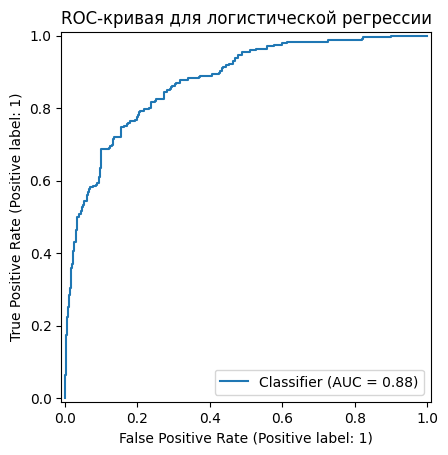

In [10]:
best_row = results_df.sort_values('roc_auc', ascending=False).iloc[0]
best_C = best_row['C']

pipe.set_params(logreg__C=best_C)
pipe.fit(X_train, y_train)

y_proba_best = pipe.predict_proba(X_test)[:, 1]

RocCurveDisplay.from_predictions(y_test, y_proba_best)
plt.title('ROC-кривая для логистической регрессии')
plt.show()

## 7. Сравнение моделей и выводы

- Логистическая регрессия значительно превосходит бейзлайн по ROC-AUC.
- Accuracy также выше, что говорит о полезности признаков.
- Значение параметра C влияет на качество, оптимальное значение находится экспериментально.
- Логистическая регрессия выглядит разумной моделью для данной задачи как интерпретируемый и устойчивый метод.